# Miniproject 3: Poem Generation

### Download Data

In [31]:
import requests

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


## Get Rhymes from CMU Dictionary

In [32]:
from nltk.corpus import cmudict

# nltk.download("cmudict")

def rhyme_endings(words):
    word_dict = cmudict.dict()
    ss = {}

    for word in words:
        try:
            tmp = word_dict[word.lower()]
            mat = []
            for i in range(len(tmp)):
                w = tmp[i]
                for j in reversed(range(len(w))):
                    if w[j][-1] == "1":
                        mat.append(w[j:])
                        break

            ss[word] = mat
        except:  # noqa: E722
            ss[word] = []
            pass

    return ss


def find_rhymes(word, ss):
    tmp = []
    end = ss[word]
    for e in end:
        for key in ss.keys():
            if e in ss[key]:
                if key == word:
                    continue
                tmp.append(key)

    return set(tmp)


## Hidden Markov Files

In [33]:
import numpy as np
from wordcloud import WordCloud
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import urllib.request


class HiddenMarkovModel:
    """
    Class implementation of Hidden Markov Models.
    """

    def __init__(self, A, O):
        """
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        """

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1.0 / self.L for _ in range(self.L)]

    def viterbi(self, x):
        """
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        """

        M = len(x)  # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0.0 for _ in range(self.L)] for _ in range(M)]
        seqs = [["" for _ in range(self.L)] for _ in range(M)]

        max_seq = ""

        for i in range(self.L):
            probs[0][i] = self.A_start[i] * self.O[i][x[0]]
            seqs[0][i] = str(i)

        for j in range(1, M):  # each obervation
            xj = x[j]
            for i in range(self.L):  # each state
                tmp = [0.0 for _ in range(self.L)]
                for s in range(self.L):
                    tmp[s] = probs[j - 1][s] * self.A[s][i] * self.O[i][xj]
                probs[j][i] = max(tmp)
                idx = tmp.index(max(tmp))
                seqs[j][i] = seqs[j - 1][idx] + str(i)
        max_prob_idx = (probs[-1]).index(max(probs[-1]))
        max_seq = seqs[-1][max_prob_idx]

        return max_seq

    def forward(self, x, normalize=False):
        """
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        """

        M = len(x)  # Length of sequence.
        alphas = [[0.0 for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
            alphas[0][i] = 1
            alphas[1][i] = self.A_start[i] * self.O[i][x[0]]

        for j in range(2, M + 1):  # each obervation
            xj = x[j - 1]
            for i in range(self.L):  # each state
                tmp = 0
                for a in range(self.L):
                    tmp += alphas[j - 1][a] * self.A[a][i]
                alphas[j][i] = self.O[i][xj] * tmp

        if normalize:
            for j in range(M + 1):
                sum_j = sum(alphas[j])
                for i in range(self.L):
                    if sum_j != 0:
                        alphas[j][i] = alphas[j][i] / sum_j

        return alphas

    def backward(self, x, normalize=False):
        """
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        """

        M = len(x)  # Length of sequence.
        betas = [[0.0 for _ in range(self.L)] for _ in range(M + 1)]

        for z in range(self.L):
            betas[-1][z] = 1

        for i in range(M - 1, -1, -1):  # each obervation
            xi = x[i]
            for z in range(self.L):  # each state
                for j in range(self.L):
                    betas[i][z] += betas[i + 1][j] * self.A[z][j] * self.O[j][xi]

        if normalize:
            for j in range(M + 1):
                sum_j = sum(betas[j])
                for z in range(self.L):
                    if sum_j != 0:
                        betas[j][z] = betas[j][z] / sum_j

        return betas

    def unsupervised_learning(self, X, N_iters):
        """
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        """
        L = len(self.A)
        D = len(self.O[0])

        for it in range(N_iters):
            A_new = [[0.0 for _ in range(L)] for _ in range(L)]
            O_new = [[0.0 for _ in range(D)] for _ in range(L)]
            for xi in range(len(X)):
                x = X[xi]
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)
                sum_a = [
                    sum(
                        sum(
                            alphas[j - 1][l]
                            * self.O[k][x[j]]
                            * self.A[l][k]
                            * betas[j][k]
                            for l in range(L)
                        )
                        for k in range(L)
                    )
                    for j in range(1, len(x))
                ]
                sum_o = [
                    sum(alphas[j][l] * betas[j][l] for l in range(L))
                    for j in range(len(x))
                ]
                for a in range(L):
                    for j, xj in enumerate(x):
                        if sum_o[j] != 0:
                            O_new[a][xj] += alphas[j][a] * betas[j][a] / sum_o[j]
                        if j != 0:
                            for b in range(L):
                                xj1 = x[j]
                                if sum_a[j - 1] != 0:
                                    A_new[a][b] += (
                                        alphas[j - 1][a]
                                        * self.O[b][xj1]
                                        * self.A[a][b]
                                        * betas[j][b]
                                        / sum_a[j - 1]
                                    )

            for i in range(len(O_new)):
                norm = sum(O_new[i])
                for j in range(len(O_new[i])):
                    if norm != 0:
                        O_new[i][j] /= norm

            for i in range(len(A_new)):
                norm = sum(A_new[i])
                for j in range(len(A_new[i])):
                    if norm != 0:
                        A_new[i][j] /= norm

            normA = 0
            for i in range(self.L):
                for j in range(self.L):
                    normA += abs(self.A[i][j] - A_new[i][j])

            normA /= self.L * self.L

            normO = 0
            for i in range(self.L):
                for j in range(self.D):
                    normO += abs(self.O[i][j] - O_new[i][j])

            normO /= self.L * self.D

            # print(normO, normA)

            if (normA < 1e-7) and (normO < 1e-7):
                print(f"Stopped after {it} iterations")
                return

            self.O = O_new
            self.A = A_new

    def generate_emission(self, M, endings, obs_map, obs_map_r, syllable, seed=None):
        """
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        """

        lines = []

        for line in range(2):
            syl = False
            while syl is False:
                emission = []
                states = []
                rng = np.random.default_rng()
                rints = rng.random(size=(M, 2))

                y = int((rints[0, 0]) // (1 / self.L))

                for m in range(M):
                    states.append(y)

                    x_bin = np.zeros((self.D - 1,))
                    xo = self.O[y]
                    for i in range(self.D - 1):
                        x_bin[i] = xo[i] + x_bin[i - 1]
                    xm = rints[m, 1]
                    x = len(np.where(xm > x_bin)[0])
                    if m == 0:
                        if line == 0:
                            num_rhymes = len(find_rhymes(obs_map_r[x], endings))
                            while num_rhymes < 1:
                                xm = rng.random()
                                x = len(np.where(xm > x_bin)[0])
                                num_rhymes = len(find_rhymes(obs_map_r[x], endings))
                            x_start = x
                        elif line == 1:
                            rhymes = find_rhymes(obs_map_r[x_start], endings)
                            # print(rhymes, obs_map_r[x_start])
                            x_bin_new = np.zeros((len(rhymes),))
                            for j, i in enumerate(rhymes):
                                idx = obs_map[i]
                                x_bin_new[j] = xo[idx]
                            x_bin_new /= sum(x_bin_new)
                            x_bin_new_total = np.zeros((len(rhymes) - 1,))
                            for i in range(len(rhymes) - 1):
                                x_bin_new_total[i] = (
                                    x_bin_new[i] + x_bin_new_total[i - 1]
                                )
                            x_idx = len(np.where(xm > x_bin_new_total)[0])
                            for j, i in enumerate(rhymes):
                                if j == x_idx:
                                    x = obs_map[i]
                    emission.append(x)

                    if m != M - 1:
                        y_bin = np.zeros((self.L - 1,))
                        yo = self.A[y]
                        for i in range(self.L - 1):
                            y_bin[i] = yo[i] + y_bin[i - 1]
                        ym = rints[m + 1, 0]
                        y = len(np.where(ym > y_bin)[0])

                syl_count = 0
                sentence = []
                for i, e in enumerate(emission):
                    if syl_count == 10:
                        lines.append(sentence)
                        syl = True
                        break
                    if i != 0:
                        syl_count += int(syllable[obs_map_r[e]][0])
                        sentence.append(e)
                    else:
                        syl_count += int(syllable[obs_map_r[e]][1])
                        sentence.append(e)

        return lines, states


def unsupervised_HMM(X, n_states, N_iters, seed=None):
    """
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.

        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    """
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM


def sample_sentence(
    hmm, obs_map, obs_map_r, syllable, endings, n_syl=10, n_lines=14, seed=None
):
    sonnet = []

    for n in range(n_lines):
        # Sample and convert sentence.
        emissions, states = hmm.generate_emission(
            n_syl, endings, obs_map, obs_map_r, syllable, seed=seed
        )

        for emission in emissions:
            sentence = [obs_map_r[i] for i in reversed(emission)]
            sonnet.append(sentence)

    return sonnet


####################
# WORDCLOUD FUNCTIONS
####################


def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r : d - r, -r : d - r]
    circle = x**2 + y**2 <= r**2

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

    plt.close("all")

    # Generate a wordcloud image.
    wordcloud = WordCloud(
        random_state=0, max_words=max_words, background_color="white", mask=mask()
    ).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud


def states_to_wordclouds(
    hmm,
    obs_map,
    obs_map_r,
    syllable,
    endings,
    n_syl=10,
    n_lines=14,
    max_words=50,
    show=True,
    seed=None,
):
    # Initialize.
    n_states = len(hmm.A)
    wordclouds = []

    sonnet = []

    for n in range(int(n_lines / 2)):
        # Sample and convert sentence.
        emissions, states = hmm.generate_emission(
            n_syl, endings, obs_map, obs_map_r, syllable, seed=seed
        )

        for emission in emissions:
            for i in reversed(emission):
                sonnet.append(i)

    emission = flatten(sonnet)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = " ".join(sentence)

        try:
            wordclouds.append(
                text_to_wordcloud(
                    sentence_str, max_words=max_words, title="State %d" % i, show=show
                )
            )
        except:
            pass

    return wordclouds


####################
# HMM VISUALIZATION FUNCTIONS
####################


def visualize_sparsities(hmm, O_max_cols=50000, O_vmax=0.1):
    plt.close("all")
    plt.set_cmap("viridis")

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title("Sparsity of A matrix")
    plt.show()

    O_vmax = max(max(hmm.O))

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:O_max_cols], vmax=O_vmax, aspect="auto")
    plt.colorbar()
    plt.title("Sparsity of O matrix")
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################


def animate_emission(
    hmm, obs_map, obs_map_r, M=8, height=12, width=12, delay=1, seed=None
):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06

    # Initialize.
    n_states = len(hmm.A)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid("off")
    plt.axis("off")
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(
            wordcloud.to_array(),
            extent=(x - r, x + r, y - r, y + r),
            aspect="auto",
            zorder=-1,
        )

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, "", fontsize=24)

    # Make the arrows.
    zorder_mult = n_states**2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)

            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(
                    x_i + (r / d + arrow_p1) * dx + arrow_p2 * dy,
                    y_i + (r / d + arrow_p1) * dy + arrow_p2 * dx,
                    (1 - 2 * r / d - arrow_p3) * dx,
                    (1 - 2 * r / d - arrow_p3) * dy,
                    color=(1 - hmm.A[i][j],) * 3,
                    head_width=arrow_size,
                    head_length=arrow_size,
                    zorder=int(hmm.A[i][j] * zorder_mult),
                )
            else:
                arrow = ax.arrow(
                    x_i,
                    y_i,
                    0,
                    0,
                    color=(1 - hmm.A[i][j],) * 3,
                    head_width=arrow_size,
                    head_length=arrow_size,
                    zorder=int(hmm.A[i][j] * zorder_mult),
                )

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color("red")
            elif i == 1:
                arrows[states[0]][states[0]].set_color(
                    (1 - hmm.A[states[0]][states[0]],) * 3
                )
                arrows[states[i - 1]][states[i]].set_color("red")
            else:
                arrows[states[i - 2]][states[i - 1]].set_color(
                    (1 - hmm.A[states[i - 2]][states[i - 1]],) * 3
                )
                arrows[states[i - 1]][states[i]].set_color("red")

            # Set text.
            text.set_text(
                " ".join([obs_map_r[e] for e in emission][: i + 1]).capitalize()
            )

            return arrows + [text]

    # Animate!
    print("\nAnimating...")
    anim = FuncAnimation(fig, animate, frames=M + delay, interval=1000)

    return anim


class Utility:
    """
    Utility for the problem files.
    """

    def __init__():
        pass

    @staticmethod
    def load_sequence(n):
        """
        Load the file 'sequence_data<n>.txt' for a given n.
        Arguments:
            n:          Sequence index.
        Returns:
            A:          The transition matrix.
            O:          The observation matrix.
            seqs:       Input sequences.
        """
        A = []
        O = []
        seqs = []

        # For each file:
        with urllib.request.urlopen(
            f"https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/set6/data/sequence_data{n}.txt"
        ) as f:
            # Read the parameters.
            L, D = [int(x) for x in f.readline().decode("utf-8").strip().split("\t")]

            # Read the transition matrix.
            for i in range(L):
                A.append(
                    [float(x) for x in f.readline().decode("utf-8").strip().split("\t")]
                )

            # Read the observation matrix.
            for i in range(L):
                O.append(
                    [float(x) for x in f.readline().decode("utf-8").strip().split("\t")]
                )

            # The rest of the file consists of sequences.
            while True:
                seq = f.readline().decode("utf-8").strip()
                if seq == "":
                    break
                seqs.append([int(x) for x in seq])

        return A, O, seqs

    @staticmethod
    def load_ron():
        """
        Loads the file 'ron.txt'.
        Returns:
            moods:      Sequnces of states, i.e. a list of lists.
                        Each sequence represents half a year of data.
            mood_map:   A hash map that maps each state to an integer.
            genres:     Sequences of observations, i.e. a list of lists.
                        Each sequence represents half a year of data.
            genre_map:  A hash map that maps each observation to an integer.
        """
        moods = []
        mood_map = {}
        genres = []
        genre_map = {}
        mood_counter = 0
        genre_counter = 0

        with urllib.request.urlopen(
            "https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/set6/data/ron.txt"
        ) as f:
            mood_seq = []
            genre_seq = []

            while True:
                line = f.readline().decode("utf-8").strip()

                if line == "" or line == "-":
                    # A half year has passed. Add the current sequence to
                    # the list of sequences.
                    moods.append(mood_seq)
                    genres.append(genre_seq)
                    # Start new sequences.
                    mood_seq = []
                    genre_seq = []

                if line == "":
                    break
                elif line == "-":
                    continue

                mood, genre = line.split()

                # Add new moods to the mood state hash map.
                if mood not in mood_map:
                    mood_map[mood] = mood_counter
                    mood_counter += 1

                mood_seq.append(mood_map[mood])

                # Add new genres to the genre observation hash map.
                if genre not in genre_map:
                    genre_map[genre] = genre_counter
                    genre_counter += 1

                # Convert the genre into an integer.
                genre_seq.append(genre_map[genre])

        return moods, mood_map, genres, genre_map

    @staticmethod
    def load_ron_hidden():
        """
        Loads the file 'ron.txt' and hides the states.
        Returns:
            genres:     The observations.
            genre_map:  A hash map that maps each observation to an integer.
        """
        moods, mood_map, genres, genre_map = Utility.load_ron()

        return genres, genre_map


def flatten(lst: any) -> any:
    flattened_list = []
    for item in lst:
        flattened_list.append(item)
    return flattened_list


def state_top_words(hmm, obs_map_r, n_words=10):
    for state, O_row in enumerate(hmm.O):
        O_row = np.array(O_row)
        top_words = np.argpartition(O_row, -n_words)[-n_words:]
        s = []
        for w in top_words:
            s.append(obs_map_r[w])
        print(f"State: {state}")
        print(", ".join(s).capitalize())


## Read syllable txt file

In [34]:
def syllable_read(file):
    syllable = open(file, "r")
    syl = {}

    for x in syllable:
        w = x.split(" ")
        name = (w[0]).strip()
        name = name.replace("\n", "")
        if (name[0] == "'") or (name[-1] == "'"):
            name = name.replace("'", "")
        tmp = ["" for _ in range(2)]
        for j in range(1, len(w)):
            if len(w) > 2:
                if "E" in w[1]:
                    tmp[0] = (w[2]).replace("\n", "").replace("E", "")
                    tmp[1] = (w[1]).replace("\n", "").replace("E", "")
                elif "E" in w[2]:
                    tmp[0] = (w[1]).replace("\n", "").replace("E", "")
                    tmp[1] = w[2]
                else:
                    tmp[0] = (w[1]).replace("\n", "").replace("E", "")
                    tmp[1] = (w[2]).replace("\n", "").replace("E", "")
            else:
                tmp[0] = (w[1]).replace("\n", "").replace("E", "")
                tmp[1] = (w[1]).replace("\n", "").replace("E", "")

            syl[name] = tmp

    syllable.close()

    return syl


## Read Sonnet

In [35]:
def Sonnet(file):
    Sonnet = []
    Sonnets = []

    f = open("shakespeare.txt", "r")
    c = 1
    cc = 0
    for x in f:
        w = x.split(" ")
        if w[-1] == f"{c}\n":
            c += 1
            if cc == 14:
                Sonnets.append(Sonnet)
            Sonnet = []
            cc = 0
            continue
        if w[0] == "\n":
            continue
        Sonnet.append(w)
        cc += 1

    f.close()

    words = []

    c = 0
    for Sonnet in Sonnets:
        for line in Sonnet:
            for w in line:
                w = (
                    w.replace(",", "")
                    .replace("\n", "")
                    .replace(":", "")
                    .replace(";", "")
                    .replace(".", "")
                    .replace("(", "")
                    .replace(")", "")
                    .replace("!", "")
                    .replace("?", "")
                )
                if w != "":
                    if (w[-1] == "'") or (w[0] == "'"):
                        w = w.replace("'", "")
                    words.append(w.lower())

    words = set(words)

    obs_map = {}
    obs_map_r = {}

    for i, w in enumerate(words):
        obs_map[w] = i
        obs_map_r[i] = w

    lines = [[0, 2], [1, 3], [4, 6], [5, 7], [8, 10], [9, 11], [12, 13]]
    # lines = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13]]

    rhyme_lines = []
    obs_lines = []

    for Sonnet in Sonnets:
        for j in lines:  # get list of 2 lines needed
            line = []
            obs = []
            for k in j:  # go through those 2 lines
                for l in reversed(Sonnet[k]):  # go word by word
                    if l == "":
                        continue
                    w = (
                        l.replace(",", "")
                        .replace(":", "")
                        .replace("\n", "")
                        .replace(";", "")
                        .replace(".", "")
                        .replace("(", "")
                        .replace(")", "")
                        .replace("!", "")
                        .replace("?", "")
                    ).lower()
                    if w != "":
                        if (w[-1] == "'") or (w[0] == "'"):
                            w = w.replace("'", "")
                        line.append(w)
                        obs.append(obs_map[w])
            rhyme_lines.append(line)
            obs_lines.append(obs)

    return obs_lines, obs_map, obs_map_r, words


### Importing packages \& Preprocessing

In [36]:
obsSS, ss_obs_map, ss_obs_map_r, unique_words = Sonnet("shakespeare.txt")

# process data (Syllables)
syllables = syllable_read('syllable_dict.txt')

ss_endings = rhyme_endings(unique_words)

# print(len(obsSS))

# Implementing Models

## HMM Code

In [ ]:
HMM5 = unsupervised_HMM(obsSS, n_states = 5, N_iters = 10000, seed = None)

Than tongue-tied and born love catch a me slay
Lengths all goodness me thoughts be be behold
See he his but mansion before the a
Waste light and and foul presagers he hold
And her wrong mistaking loved not this she
They which prove for as every canst amends
Hold of alone they my needs the hell thee
Shall you nothing your to sweet world befriends
As like yet but sleep brass before must is
So to grows dark i art you your despising
I my other love she is that ye tis
Thy so not mine when me oft of arising
Worth you thought thriftless be doth dwell and at
No lines a alone advantage each that

State: 0
Love, of, not, thou, to, thy, that, i, my, and
State: 1
The, thee, be, in, and, of, to, my, thy, i
State: 2
I, that, to, and, in, thou, of, thy, my, the
State: 3
That, his, to, a, my, the, with, in, and, of
State: 4
Is, my, to, of, the, you, in, i, that, and


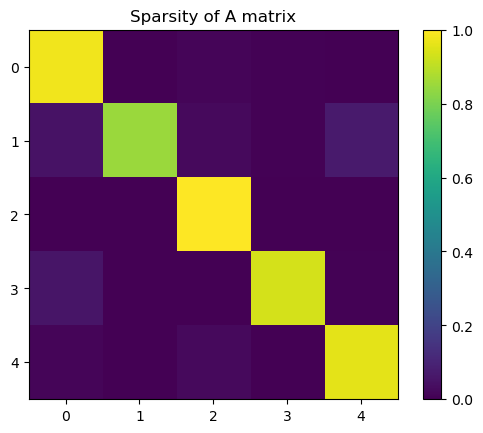

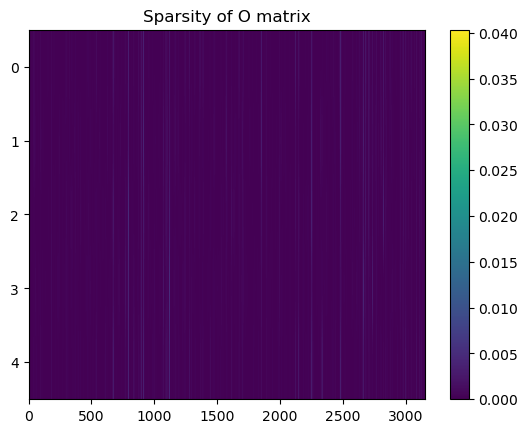

In [ ]:
sonnet = sample_sentence(HMM5, ss_obs_map, ss_obs_map_r, syllables, ss_endings, n_syl=10, n_lines=14)

lines = [0, 2, 1, 3, 4, 6, 5, 7, 8, 10, 9, 11, 12, 13]
for i in lines:
    s = sonnet[i]
    print(" ".join(s).capitalize())

print('')

state_top_words(HMM5, ss_obs_map_r)

visualize_sparsities(HMM5, O_max_cols=500)

In [ ]:
HMM7 = unsupervised_HMM(obsSS, n_states = 7, N_iters = 10000, seed = None)

Stopped after 863 iterations


Not never forgoing i meadows it
That unknown find and so that from tend eyes
Part far and i now no my making wit
I my they these of thing remembered lies
I triumphant worms who each fierce that grace
My mad varying breast if nor dearly hearts
Unseen my second all works youth deface
Wires and hath very slain should alone parts
Than where other confounds some that a power
One not present i do whether nature not
Time come against the stay present mine hour
From unperfect self all tyranny hot
The and common was our beautiful end
Interim distance not on the but of spend
State: 0
Your, i, my, with, to, in, that, the, of, and
State: 1
That, to, his, thy, my, in, and, the, of, with
State: 2
Self, of, with, in, is, i, thy, to, and, my
State: 3
In, a, thou, of, to, the, that, i, and, my
State: 4
Thy, have, to, and, when, that, the, of, i, in
State: 5
For, me, not, my, thy, thou, that, i, to, and
State: 6
Or, his, a, as, and, my, to, the, in, of


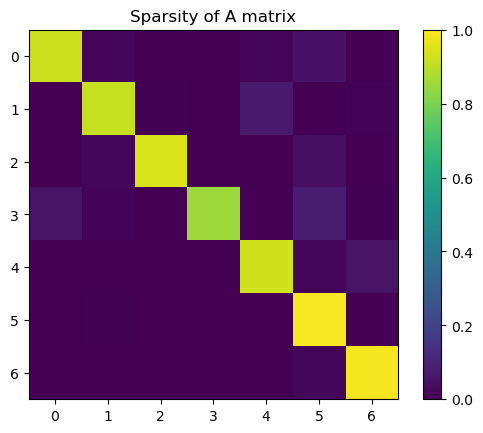

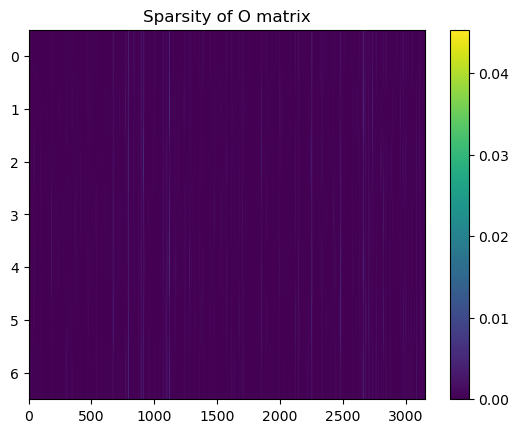

In [ ]:
sonnet = sample_sentence(HMM7, ss_obs_map, ss_obs_map_r, syllables, ss_endings, n_syl=10, n_lines=14)

lines = [0, 2, 1, 3, 4, 6, 5, 7, 8, 10, 9, 11, 12, 13]
for i in lines:
    s = sonnet[i]
    print(" ".join(s).capitalize())

print('')

state_top_words(HMM7, ss_obs_map_r)

visualize_sparsities(HMM7, O_max_cols=500)

In [ ]:
HMM10 = unsupervised_HMM(obsSS, n_states = 10, N_iters = 10000, seed = None)

Stopped after 439 iterations


A but i i disgrace thousand it place
All the provide in fair warm to outlive
State be what anew now used look disgrace
Yet merit thy under a do mine give
His fair meet by painted after in them
Nimble thou that voice that gate some she live
To more outstripped kill me than that is am
From thy i although blood while way like give
You rocks thou it young ill savage take though
End to not seasons dark o'erpressed my thee
With invited time's wit to trees to so
Beauty's evil hath tattered springs their she
Were of art truth my it be my above
Sea steal lie oft how thee pleasure kind of

State: 0
Not, that, a, of, in, and, the, to, i, my
State: 1
With, to, in, his, my, a, all, of, and, the
State: 2
Thou, love, for, is, of, my, to, the, that, and
State: 3
I, of, the, me, thy, in, and, to, my, that
State: 4
When, in, which, that, a, of, i, the, with, and
State: 5
Thee, in, and, not, to, love, my, thy, thou, i
State: 6
That, a, thy, in, my, to, with, the, of, and
State: 7
And, for, my, in, you, t

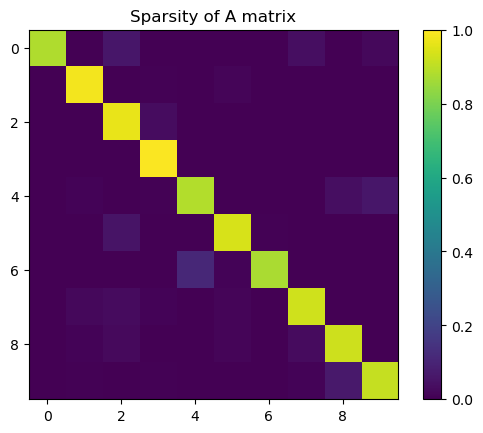

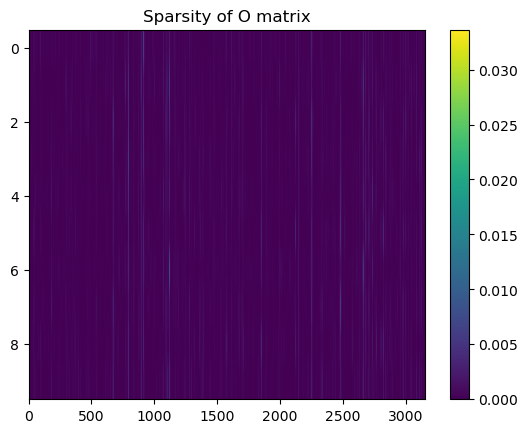

In [ ]:
sonnet = sample_sentence(HMM10, ss_obs_map, ss_obs_map_r, syllables, ss_endings, n_syl=10, n_lines=14)

lines = [0, 2, 1, 3, 4, 6, 5, 7, 8, 10, 9, 11, 12, 13]
for i in lines:
    s = sonnet[i]
    print(" ".join(s).capitalize())

print('')

state_top_words(HMM10, ss_obs_map_r)

visualize_sparsities(HMM10, O_max_cols=500)

In [ ]:
HMM15 = unsupervised_HMM(obsSS, n_states = 15, N_iters = 10000, seed = None)

Stopped after 538 iterations


Dead night which war inviting then short saw
Thy my self after grow in soon impair
All in then whose makes chiding than that draw
Not as still my face o not approve swear
Vouchsafe moan not see my mute loving go
Die to scope add jollity love with of
In such it what form his more speaking o
I moods my when you my i strong thereof
Thou cannot self all heart require of soul
Constancy are ruth so thou thither these
Thou should fairer give at dost my foul stole
On exceeded high not black than decrees
Desiring largess write thy darling had
Not one were thee raised acceptable add

State: 0
Thy, and, love, your, my, i, you, in, that, to
State: 1
In, that, the, my, a, with, of, his, to, and
State: 2
Be, me, is, i, love, not, and, thy, to, my
State: 3
When, thy, his, thou, with, in, my, and, of, the
State: 4
As, that, thee, all, the, i, my, to, and, in
State: 5
In, of, and, thou, i, that, self, to, thy, me
State: 6
Thy, a, i, my, with, and, in, that, the, of
State: 7
In, is, thy, and, the, doth,

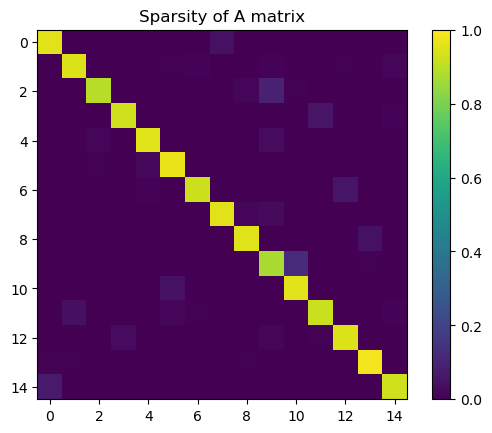

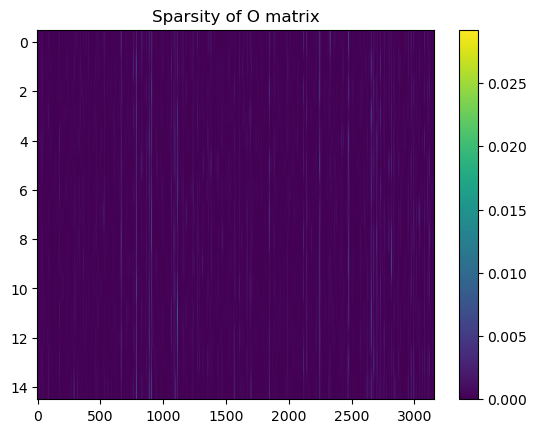

In [ ]:
sonnet = sample_sentence(HMM15, ss_obs_map, ss_obs_map_r, syllables, ss_endings, n_syl=10, n_lines=14)

lines = [0, 2, 1, 3, 4, 6, 5, 7, 8, 10, 9, 11, 12, 13]
for i in lines:
    s = sonnet[i]
    print(" ".join(s).capitalize())

print('')

state_top_words(HMM15, ss_obs_map_r)

visualize_sparsities(HMM15, O_max_cols=500)